vertex display
# µ-proton Vertex display 

In [1]:
debug = 0
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/mupClassification/sections/RdQaroundVertex/Figures/vertex_displays/'
import ROOT
from larlite import *

Welcome to ROOTaaS 6.06/02


In [2]:
from pylab import figure, title, setp, close, clf

In [3]:
from ROOT import hit,box,PandoraNuTrack,GENIEinteraction,pairVertex,AnalyseEvents

In [4]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
import sys; sys.path.insert(0, '/Users/erezcohen/larlite/UserDev/CCQEana/CCQEPackage/notebooks/'); sys.path.insert(0, '/Users/erezcohen/larlite/UserDev/mySoftware/MySoftwarePackage/mac/');
from plot_tools import *
from ccqe_notebook_tools import *
import matplotlib.colors as colors, matplotlib.patches as patches
from matplotlib.ticker import NullFormatter

In [5]:
%matplotlib inline
# %matplotlib notebook
from IPython.core.display import HTML,display
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
def get_tracks_hits_vertices( ana=None, entry=0 , debug=0 ):
    if ana is None: 
        print "ana is None! returning..."
        return
    ana.GetEntry( entry )
    tracks = ana.GetTracks()
    hits = ana.GetHits()
    vertices = ana.GetVertices()
    if debug:
        print '%d track, %d hits, %d vertices'%(int(tracks.size()),int(hits.size()),int(vertices.size()))
    for v in vertices:
        print 'vertex',v.GetVertexID(),':',v.GetTruthTopologyString()
        if v.GetTruthTopologyString()=='true non-µp pair':
            for t in v.GetTracks(): print 'track',t.GetTrackID(),'pdg',t.GetMCpdgCode()
        elif v.GetTruthTopologyString()=='true µp pair':
            g = v.GetClosestGENIE()
            print g.GetNprotons(),'protons',g.GetNneutrons(),'neutrons',g.GetNpions(),'pions'
    return hits,tracks,vertices

In [7]:
#---------------------------------------------------------------------------------------------
def plot_tracks(hits,plane,ax=None,cmap='hot_r',color='',do_add_numbers=False, do_add_text=False):
    for t in tracks:
        color, label,_ = set_color_label_cmap(t)
        w_start , t_start , w_end , t_end = t.GetStartWire(plane) , t.GetStartTime(plane) , t.GetEndWire(plane) , t.GetEndTime(plane)
        plt.plot([w_start,w_end],[t_start,t_end],color=color)
        if do_add_text: plt.text(w_start + 0.3*(w_end-w_start), t_start, label,color=color,fontsize=20)
#---------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------
def plot_hits(hits,plane,ax=None,cmap='hot_r',do_add_hit_trkKey=False,do_add_numbers=False,color=None
              ,label=None):
    
    hit_wire, hit_time, hit_charge , hit_number , hit_trkKey, hit_color = [] , [] , [] , [] , [], []
    hits_df=pd.DataFrame({})
    associated_hits=dict()
    for i_hit,hit in enumerate(hits):
        if hit.InPlane(plane):# and hit_in_box(hit,box=box):
            hit_wire.append(hit.GetWire())
            hit_time.append(hit.GetPeakT())
            hit_charge.append(hit.GetCharge())
    if debug>2: print 'len(hit_charge):',len(hit_charge)
    if len(hit_charge)>0:
        ax.scatter(hit_wire,hit_time,c=hit_charge if color is None else color
                   ,vmin=np.min(hit_charge), vmax=np.max(hit_charge),s=20, cmap='hot_r' , label=label)
    else:
        ax.scatter(hit_wire,hit_time,c=hit_charge if color is None else color,s=20, cmap='hot_r' , label=label)        
#---------------------------------------------------------------------------------------------

# prodgenie_bnb_nu_uboone_overlay_reco2

In [8]:
file=ROOT.TFile("/Users/erezcohen/Desktop/uBoone/CCQEanalysis/EventsFiles/prodgenie_bnb_nu_uboone_overlay_reco2_events.root")
tree=file.Get("EventsAnalyzer/eventsTree")
ana=AnalyseEvents(tree)

In [9]:
#---------------------------------------------------------------------------------------------    
def add_vertex_ROI( vertex=None , ax=None , plane=0 , roi_dimesions=None , color='black', alpha=0.8):
    wire,time = vertex.GetVertexWire(plane),vertex.GetVertexTime(plane)
    ax.add_patch(patches.Rectangle( (wire-roi_dimesions[0]/2,time-roi_dimesions[1]/2),   # (x,y)    
                                   roi_dimesions[0],          # width                                   
                                   roi_dimesions[1],         # height                                   
                                   fill=False,   # remove background                                   
                                   color=color ,
                                   linewidth=2,
                                   alpha=alpha
                                  ))   
    return wire,time
#---------------------------------------------------------------------------------------------        

In [10]:
#---------------------------------------------------------------------------------------------    
def get_toal_charge_in_box( hits=None , plane=0 , box_around_vertex=None ):
    Q=0.0
    for h in hits:
        if h.InPlane(plane) and h.InBox( box_around_vertex ):
            Q = Q + h.GetCharge()  
    return Q
#---------------------------------------------------------------------------------------------        

In [22]:
#---------------------------------------------------------------------------------------------    
def draw_vertex( hits=None, tracks=None , vertex=None, roi_dimesions = [100,200],  do_legend=False, legend_locs=['best','best','best'],
                leg_fontsize=20, planes=[0,1,2],tracks_leg_plane=2,figsize=(26,12),
                do_add_RdQaroundVertex=False, box_colors=['black'], box_dimesions=[(20,40)]  ):
    
    fig=plt.figure(figsize=figsize)
    for plane,p_label in zip(planes,['U','V','Y']):
        ax=fig.add_subplot(1,3,plane+1)        
        # hits
        plot_hits(hits , plane=plane , ax=ax , cmap='hot_r' )
        # tracks
        plot_tracks(tracks , plane=plane , ax=ax , do_add_text=False )
        # vertex
        plot_vertex(vertex , plane=plane , ax=ax , tracks_leg_plane=tracks_leg_plane , roi_dimesions=roi_dimesions)
        
        # get RdQ around vertex for a given box size
        labels = []
        if do_add_RdQaroundVertex:
            for box_color,box_dimesion in zip(box_colors,box_dimesions):
                RdQ = getRdQaroundVertex(vertex=vertex, ax=ax , plane=plane, hits=hits 
                                   , box_dimesion=box_dimesion, box_color=box_color)
                labels.append('$\\left(%d \\times %d\\right) = %.2f$'%(box_dimesion[0],box_dimesion[1],RdQ))
        ax.set_title(p_label+' plane',fontsize=leg_fontsize+15,y=1.02)
        # style 
        if do_legend: 
            boxes = ax.get_lines()
            boxes_leg=ax.legend(boxes,labels,loc=legend_locs[plane],handletextpad=-0.8
                                ,fontsize=leg_fontsize,markerscale=0)#(bbox_to_anchor(1,1.05),loc=2,fontsize=20)            
            boxes_leg.set_title(r'$R_{\Delta Q}$')
            setp(boxes_leg.get_title(), fontsize=leg_fontsize)
            for color,text in zip(box_colors,boxes_leg.get_texts()):
                text.set_color(color)
            for item in boxes_leg.legendHandles:
                item.set_visible(False)
        if plane>0: ax.yaxis.set_major_formatter( NullFormatter() )
        ax.xaxis.set_major_formatter( ticker.FormatStrFormatter('%d') )
        set_axes(ax,'wire','time tick' if plane==0 else '',xticks=np.linspace(np.min(ax.get_xlim()),np.max(ax.get_xlim()),5),fontsize=30)
    return fig
#---------------------------------------------------------------------------------------------            

#---------------------------------------------------------------------------------------------
def plot_vertex(vertex=None , plane=0 , ax=None , roi_dimesions = [100,200], do_add_vertex_ROI=False, tracks_leg_plane=2
                , leg_fontsize=30):
    
    # draw ROI   
    if do_add_vertex_ROI:
        add_vertex_ROI( vertex=vertex , ax=ax , plane=plane , roi_dimesions=roi_dimesions , color='salmon' , alpha=0.25)
    # hits associated with the muon and proton tracks
    muon_hits = vertex.GetMuonHits(plane)
    proton_hits = vertex.GetProtonHits(plane)
    ax.set_xlim(np.min(np.concatenate([[h.GetWire() for h in muon_hits],[h.GetWire() for h in proton_hits]]))-roi_dimesions[0]
                ,np.max(np.concatenate([[h.GetWire() for h in muon_hits],[h.GetWire() for h in proton_hits]]))+roi_dimesions[0])
    ax.set_ylim(np.min(np.concatenate([[h.GetPeakT() for h in muon_hits],[h.GetPeakT() for h in proton_hits]]))-roi_dimesions[1]
                ,np.max(np.concatenate([[h.GetPeakT() for h in muon_hits],[h.GetPeakT() for h in proton_hits]]))+roi_dimesions[1])
    # plots hits associated with the muon and proton tracks
    track_colors = []
    color , label , cmap = set_color_label_cmap(vertex.GetAssignedMuonTrack())
    track_colors.append(color)
    plot_hits( muon_hits , plane=plane , ax=ax , color=color , label=label)
    color , label , cmap = set_color_label_cmap(vertex.GetAssignedProtonTrack())
    track_colors.append(color)
    plot_hits( proton_hits , plane=plane , ax=ax , color=color , label=label) 
    tracks_leg=ax.legend(loc='best',fontsize=leg_fontsize, scatterpoints=3 , markerscale=2 )
    for color,text in zip(track_colors,tracks_leg.get_texts()):
        text.set_color(color)
    if plane==tracks_leg_plane: ax.add_artist(tracks_leg)
#---------------------------------------------------------------------------------------------    

In [23]:
#---------------------------------------------------------------------------------------------    
def getRdQaroundVertex(vertex=None, ax=None , plane=0, hits=None , box_dimesion=None
#                        , do_legend=False
                       ,box_color='black'
                       ,debug=False):
    wire,time = add_vertex_ROI( vertex=vertex , ax=ax , plane=plane, roi_dimesions=box_dimesion , color=box_color )
    box_around_vertex = box( wire-box_dimesion[0]/2 , time-box_dimesion[1]/2 , 
                             wire+box_dimesion[0]/2 , time+box_dimesion[1]/2 )
    Qtotal = get_toal_charge_in_box( hits=hits , plane=plane , box_around_vertex=box_around_vertex )
    Qmuon = get_toal_charge_in_box( hits=vertex.GetMuonHits(plane) , plane=plane , box_around_vertex=box_around_vertex )
    Qproton = get_toal_charge_in_box( hits=vertex.GetProtonHits(plane) , plane=plane , box_around_vertex=box_around_vertex )
    # print 'Qtotal,Qmuon,Qproton:',Qtotal,Qmuon,Qproton
    RdQ = (Qmuon+Qproton)/Qtotal if np.abs(Qtotal)>0 else 0
    if debug:print 'plane',plane,'Q(tracks)/Q(total):',RdQ
    return RdQ
#---------------------------------------------------------------------------------------------    

# a typical CC 1p 0$\pi$ vertex

In [24]:
hits , tracks , vertices = get_tracks_hits_vertices( ana, entry=33 , debug=True )

14 track, 9988 hits, 3 vertices
vertex 0 : cosmic pair
vertex 1 : cosmic pair
vertex 2 : true CC 1p 0π


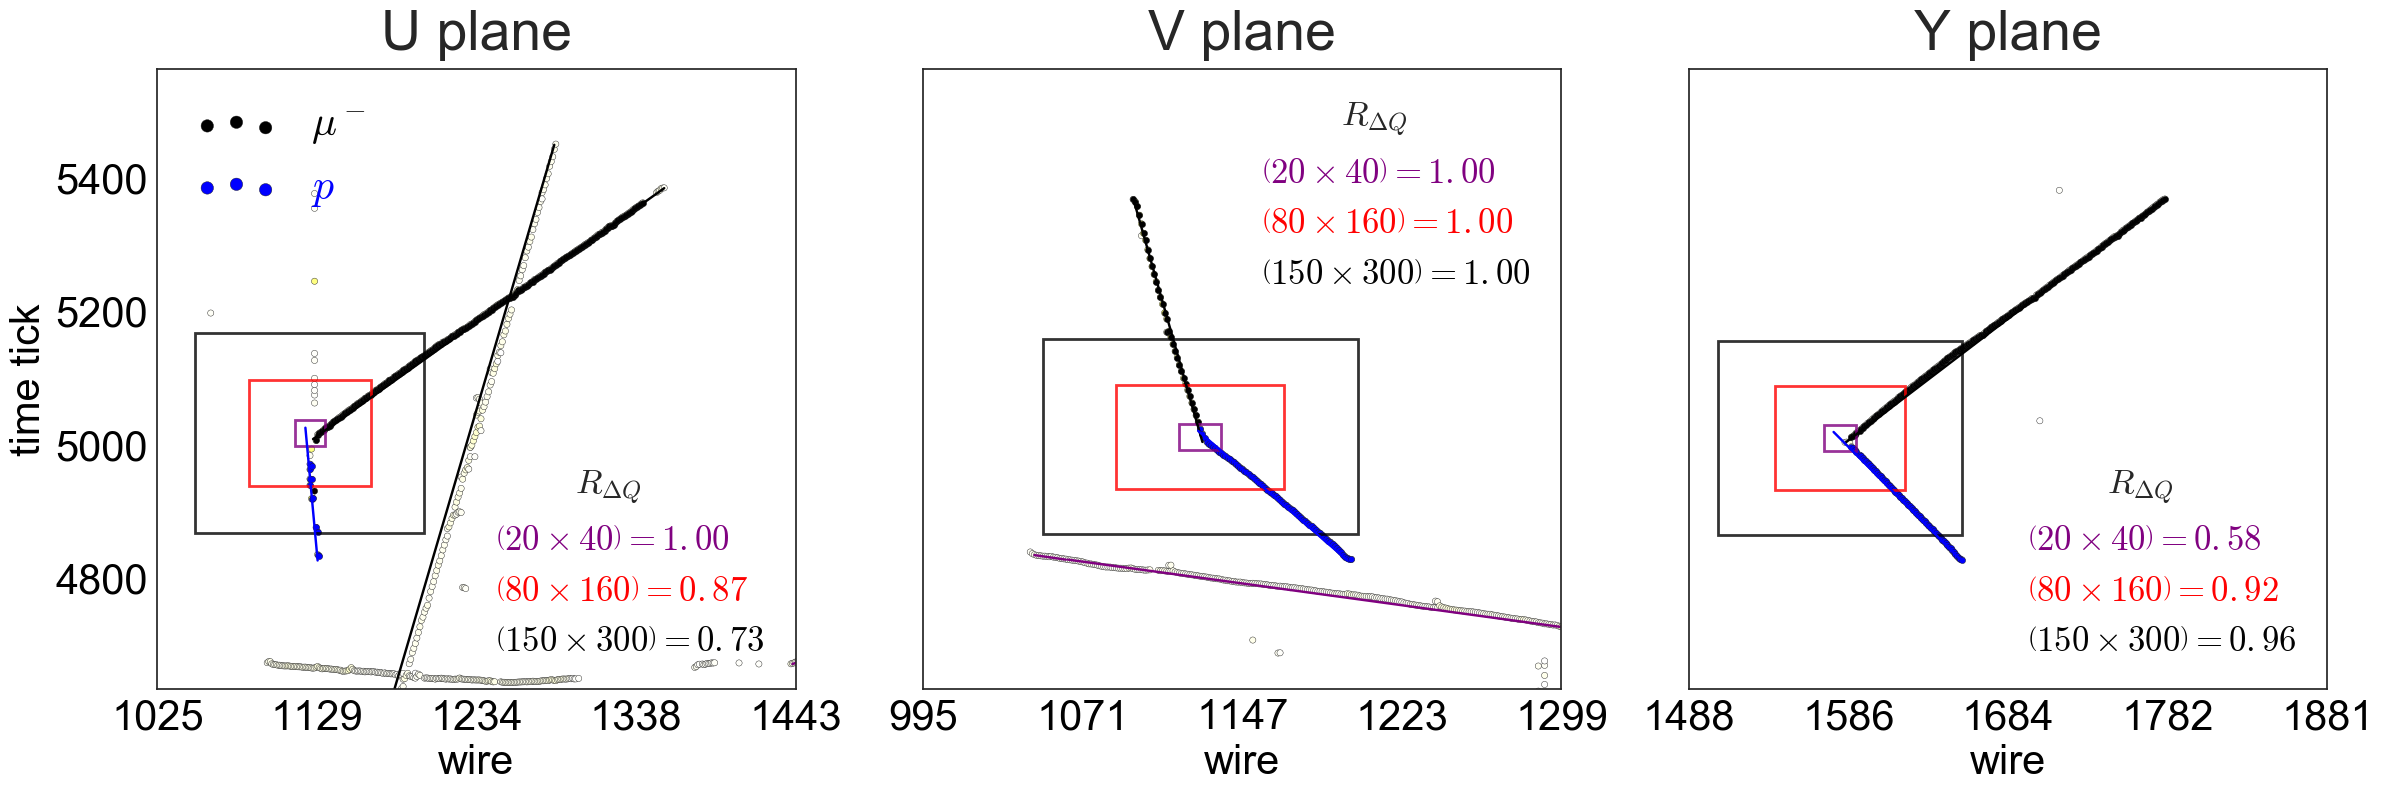

In [25]:
fig=draw_vertex( hits , tracks , vertices.at(2) , planes=[0,1,2] , tracks_leg_plane=0,figsize=(28,8)
            , do_add_RdQaroundVertex=True , leg_fontsize=25
            , box_colors=['purple','red','black'], box_dimesions=[(20,40),(80,160),(150,300)]
            , do_legend=True , legend_locs=['lower right','upper right','lower right'])
fig.savefig(figures_path+'CC1p0piVertex_33_vertex_2.pdf')

# a typical $\mu p$ vertex with additional undetected particles

In [15]:
hits , tracks , vertices = get_tracks_hits_vertices( ana, entry=43 , debug=True )

12 track, 8281 hits, 1 vertices
vertex 0 : true µp pair
3 protons 7 neutrons 1 pions


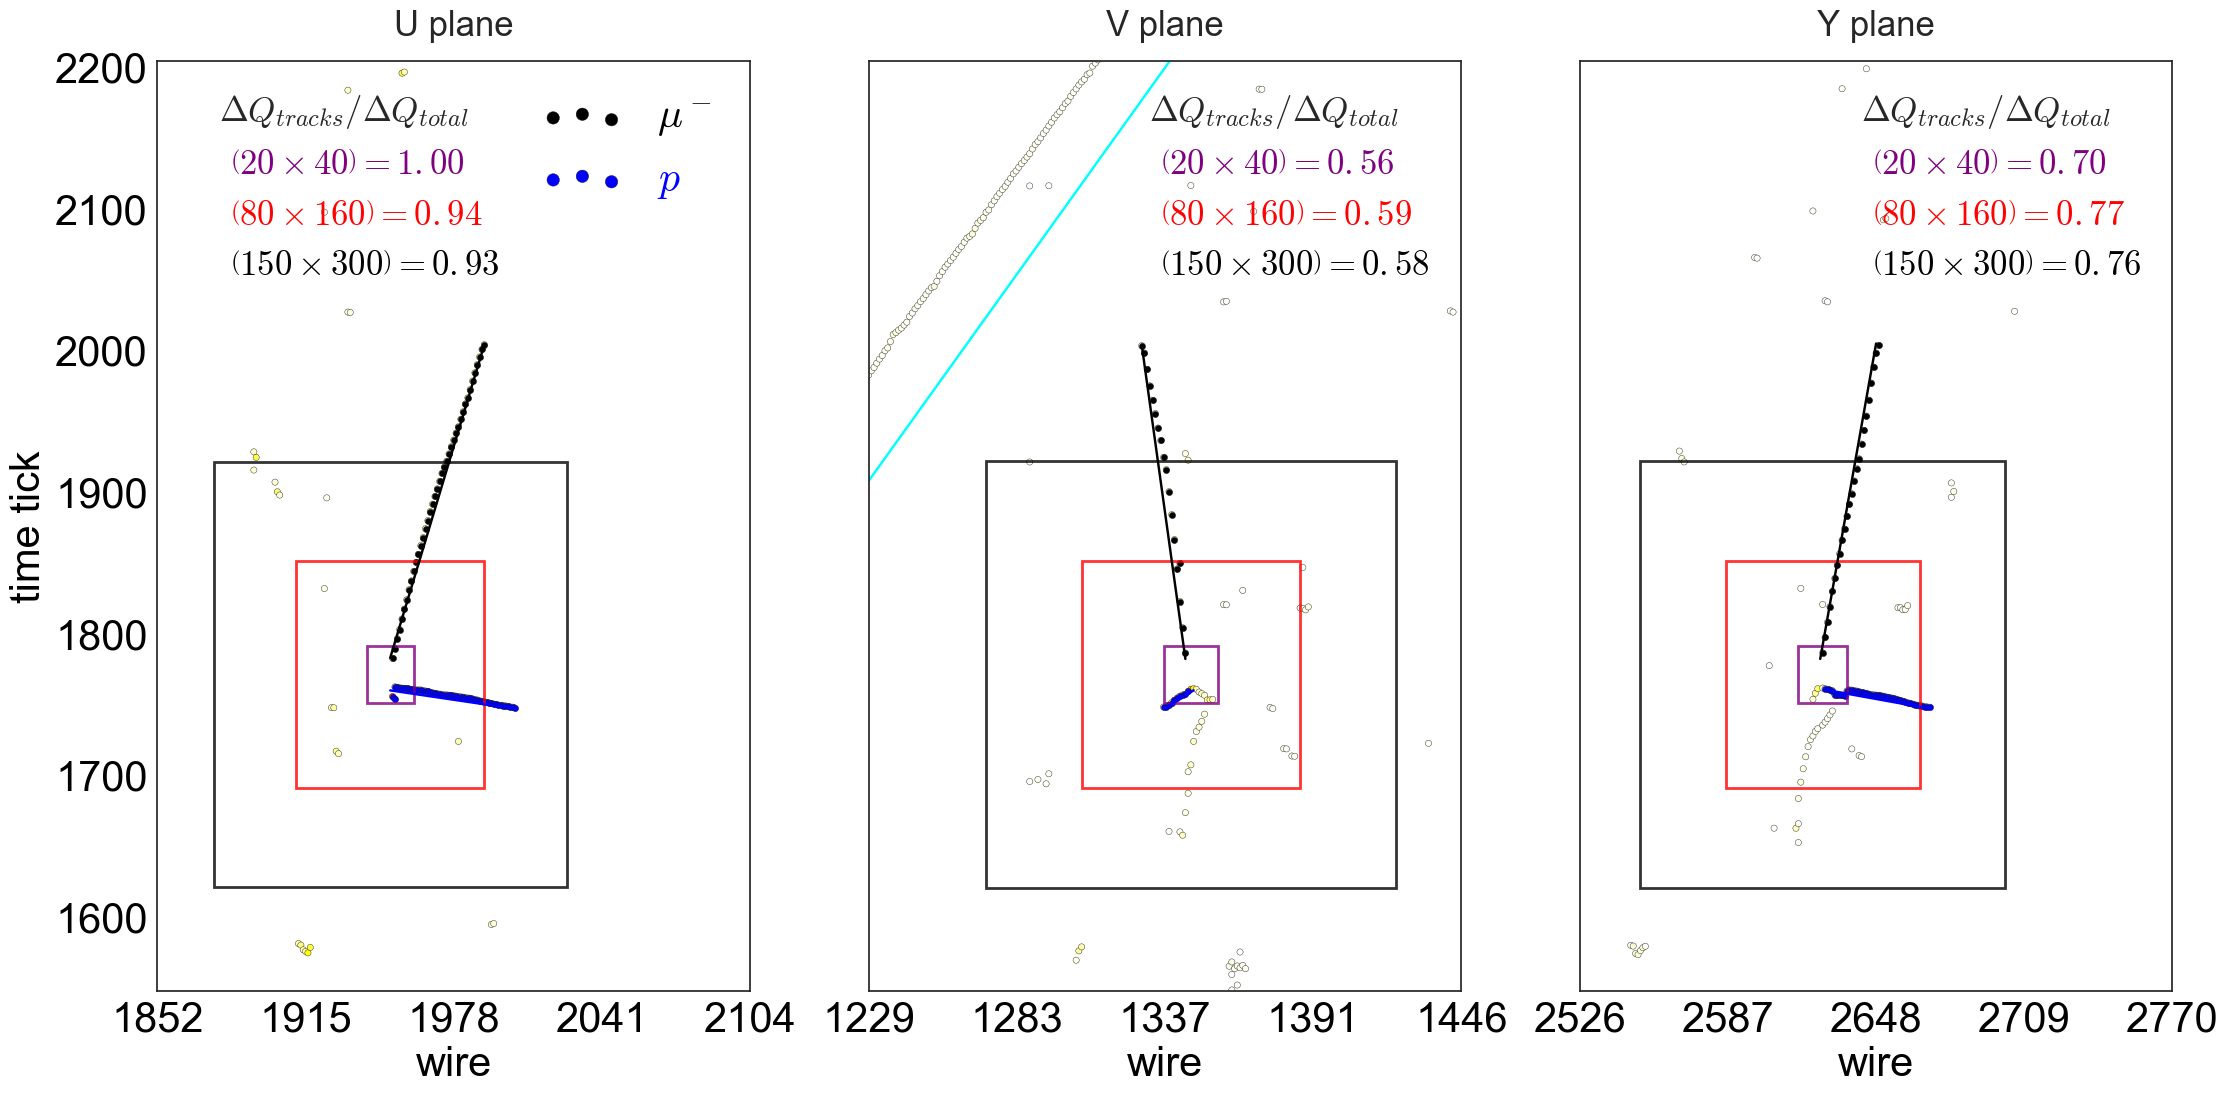

In [16]:
fig=draw_vertex( hits , tracks , vertices.at(0) , planes=[0,1,2]  , tracks_leg_plane=0,leg_fontsize=25
            , do_add_RdQaroundVertex=True            
            , box_colors=['purple','red','black'], box_dimesions=[(20,40),(80,160),(150,300)]
            , do_legend=True , legend_locs=['upper left','upper right','upper right'])
fig.savefig(figures_path+'mupVertex_43_vertex_0.pdf')

In [17]:
hits , tracks , vertices = get_tracks_hits_vertices( ana, entry=106 , debug=True )

5 track, 4123 hits, 2 vertices
vertex 0 : cosmic pair
vertex 1 : true µp pair
4 protons 4 neutrons 1 pions


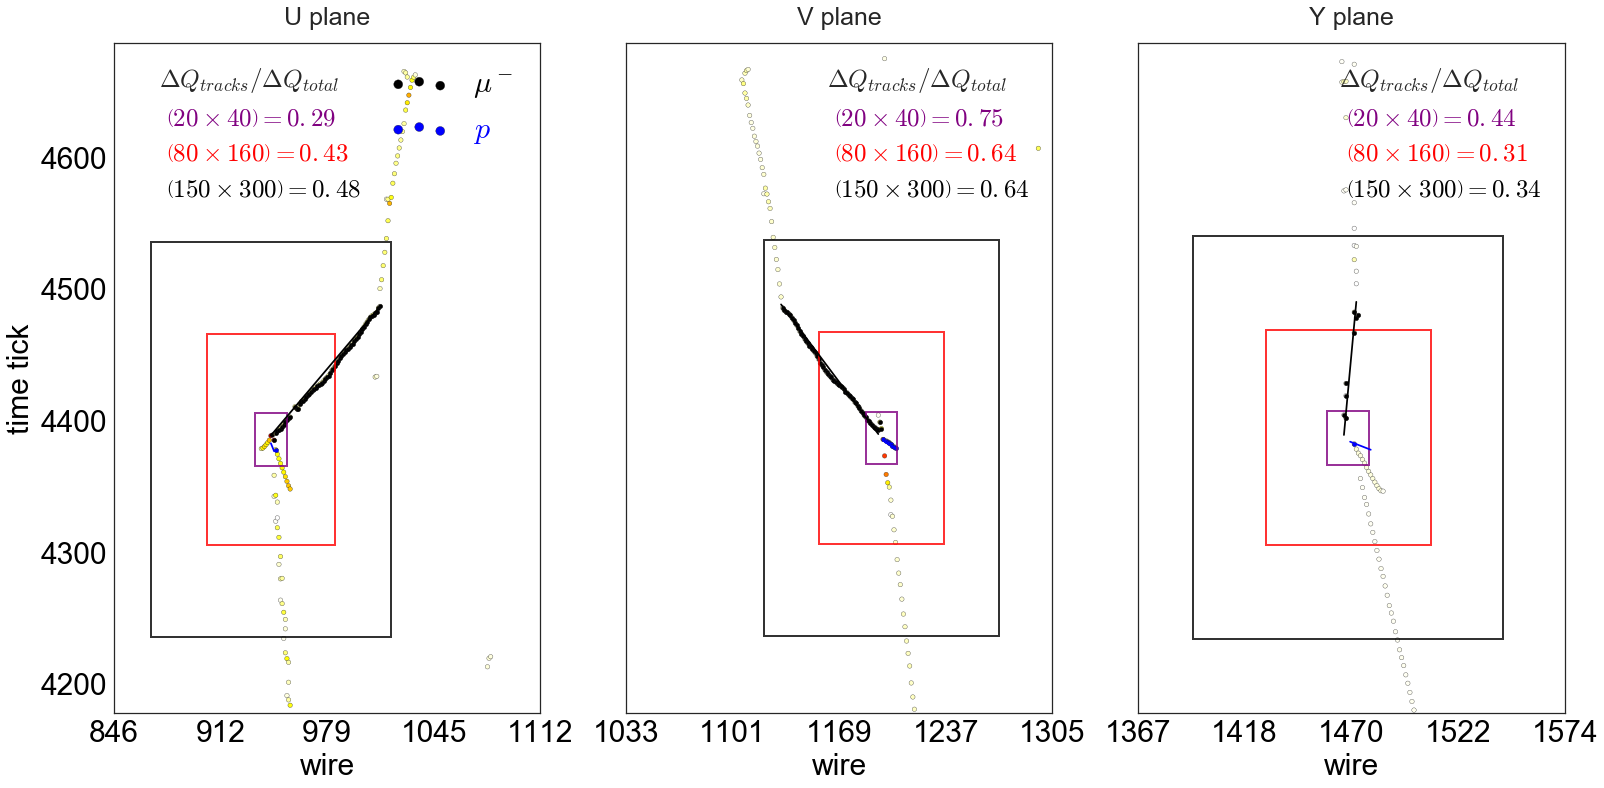

In [18]:
fig=draw_vertex( hits , tracks , vertices.at(1) , planes=[0,1,2]  , tracks_leg_plane=0,leg_fontsize=25
            , do_add_RdQaroundVertex=True            
            , box_colors=['purple','red','black'], box_dimesions=[(20,40),(80,160),(150,300)]
            , do_legend=True , legend_locs=['upper left','upper right','upper right'])
fig.savefig(figures_path+'mupVertex_106_vertex_1.pdf')

# a typical non-$\mu p$ vertex with additional undetected particles

In [19]:
hits , tracks , vertices = get_tracks_hits_vertices( ana, entry=31 , debug=True )

4 track, 3581 hits, 1 vertices
vertex 0 : true non-µp pair
track 1 pdg 2212
track 3 pdg 211


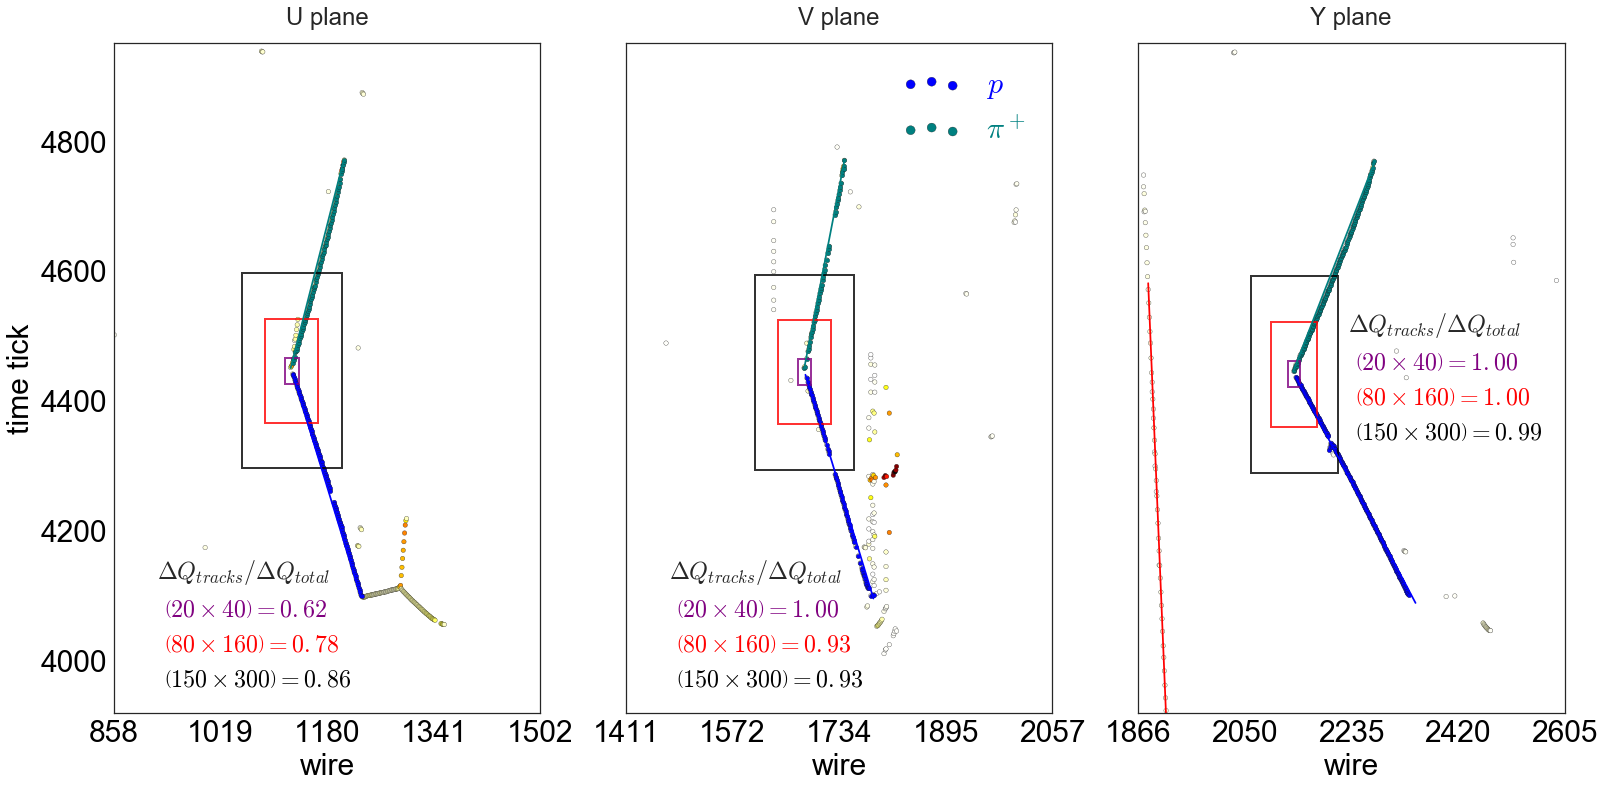

In [20]:
fig=draw_vertex( hits , tracks , vertices.at(0) , planes=[0,1,2]  , tracks_leg_plane=1, roi_dimesions = [270,180],leg_fontsize=24
            , do_add_RdQaroundVertex=True            
            , box_colors=['purple','red','black'], box_dimesions=[(20,40),(80,160),(150,300)]
            , do_legend=True , legend_locs=['lower left','lower left','center right'])
fig.savefig(figures_path+'OtherPairVertex_31_vertex_0.pdf')